In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc
import random

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [2]:
# allows nice plots that can be redrawn
%matplotlib notebook

# Task 2.1 - Nonlinear Modelling

## Generating Training Data

Now that I wish to improve the state change model with nonlinear basis functions, the first task is to generate training data. For task 1.3 I used uniformly distributed random datapoints, but this time I am using a sobol sequence to generate more evenly spaced data.

In [3]:
N = 512

np.random.seed(4)

random_positions  = np.random.rand( N ) * 20 - 10
random_velocities = np.random.rand( N ) * 20 - 10
random_angles     = np.random.rand( N ) * np.pi * 2 - np.pi
random_angvels    = np.random.rand( N ) * 30 - 15

# stack random values into 512 state vectors

X_random = initial_states = np.stack( [
    random_positions,
    random_velocities,
    random_angles,
    random_angvels
] ).T


# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get 512 initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 10, np.pi, 15 ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


M = 32
kernel_centres = X[:M]

## Sobol Sequence

<IPython.core.display.Javascript object>


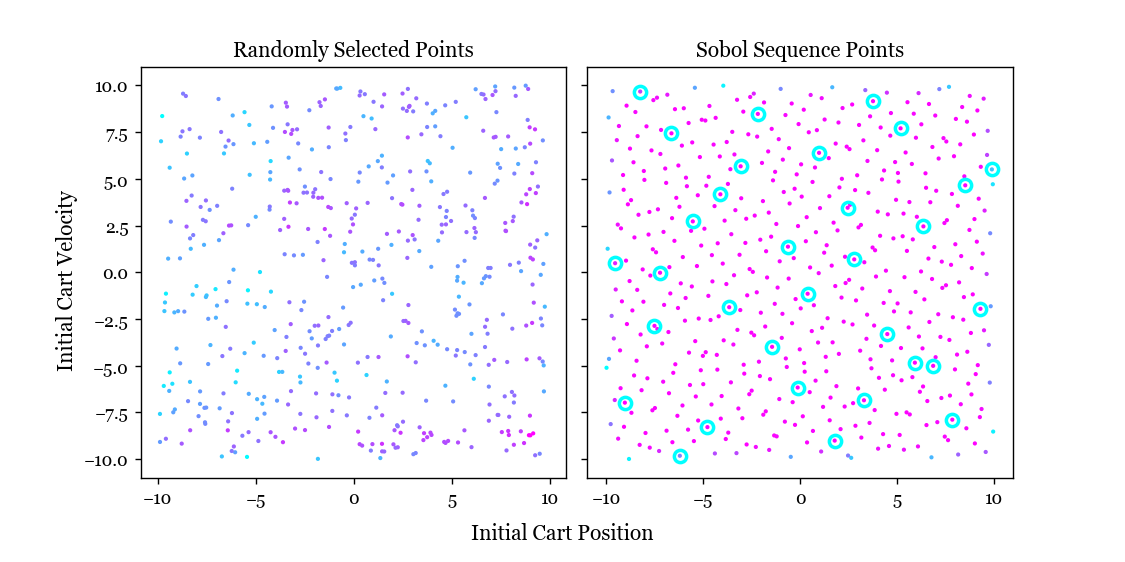

Text(0.5, 0.05, 'Initial Cart Position')

In [4]:
fig, (ax1, ax2) = plt.subplots( 1, 2, num=1, sharey=True, figsize=(9,4.5) )
fig.subplots_adjust(wspace=0.05, bottom=0.15)

c = np.zeros( N )
for i, x in enumerate( X_random ):
    
    c[i] = np.linalg.norm( np.exp( -3*(X_random[:,0:2] - x[0:2])**2 ) )

ax1.scatter( X_random[:,0], X_random[:,1], s=2, c=c, cmap="cool"  )

ax1.set_title( "Randomly Selected Points" )


c = np.zeros( N )
for i, x in enumerate( X_sobol ):
    
    c[i] = np.linalg.norm( np.exp( -3*(X_sobol[:,0:2] - x[0:2])**2 ) )


ax2.scatter( X_sobol[:,0], X_sobol[:,1], s=2, c=c, cmap="cool"  )
ax2.scatter( kernel_centres[:,0], kernel_centres[:,1], s=50, color=[0,0,0,0], edgecolors="cyan", linewidths=2  )

ax2.set_title( "Sobol Sequence Points" )


fig.text( 0.06, 0.5, "Initial Cart Velocity", rotation="vertical", ha="center", va="center", fontsize=12 )
fig.text( 0.5, 0.05, "Initial Cart Position", ha="center", va="center", fontsize=12 )


Above are scatter plots of the datapoints generated by the two methods, projected onto the plane formed by the first two state vector dimensions. The randomly selected points can be bunched up in some areas, and absent from others. The sobol sequence provides much better coverage of the state space, meaning more useful information makes it into the model.

## Selection of Kernel Centres

The sobol sequence method has another advantage: the first few generated points are also evenly spaced over the state space so they work well as kernel centres (if two kernel centres were next to each other, they would explain the same part of the data so one would be enough). This works best when the number of kernel centres is a power of two; above I have circled the first 16 points.

## Creating More Training Data

In [20]:
N = 512 * 8

np.random.seed(4)

random_positions  = np.random.rand( N ) * 20 - 10
random_velocities = np.random.rand( N ) * 20 - 10
random_angles     = np.random.rand( N ) * np.pi * 2 - np.pi
random_angvels    = np.random.rand( N ) * 30 - 15

# stack random values into 512 state vectors

X_random = initial_states = np.stack( [
    random_positions,
    random_velocities,
    random_angles,
    random_angvels
] ).T


# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get M initial states spaced in the recommended ranges
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20 ] )
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 5, 2, 1, 2 ] ) + np.array([0,0,np.pi,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]

cache["X_Y_M_N_kc_fit"] = (X, Y, M, N, kernel_centres)

## Define the Nonlinear Kernel

In [21]:

sigma = np.std( X, axis=0 ) * 0.9

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    

## Construction of Knm Matrices

In [22]:
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )

## Finding the Kernel Coefficients

In [23]:
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

cache["alpha_m_fitted"] = alpha_m
cache["kernel_centres_fitted"] = kernel_centres

## Building the Model

In [24]:
def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

## Evaluating the Model

In [10]:
# sweep over different initial pole angles and angvels and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial pole angle and angular velocity

initial_cart_positions  = np.array( [2] )
initial_cart_velocities = np.array( [4] )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps )
initial_pole_angvels    = np.linspace( -15, 15, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid(
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels 
)).T.squeeze()

# get 2d arrays of subsquent state vectors and residuals

state_changes = [ CartPole.perform_action( state ) - state for state in initial_states.reshape( (Nsteps**2,4) ) ]
state_changes = np.array( state_changes ).reshape( (Nsteps, Nsteps, 4) )

modelled_changes = [ nonlinear_model( state ) for state in initial_states.reshape( (Nsteps**2,4) ) ]
modelled_changes = np.array( modelled_changes ).reshape( (Nsteps, Nsteps, 4) )

<IPython.core.display.Javascript object>


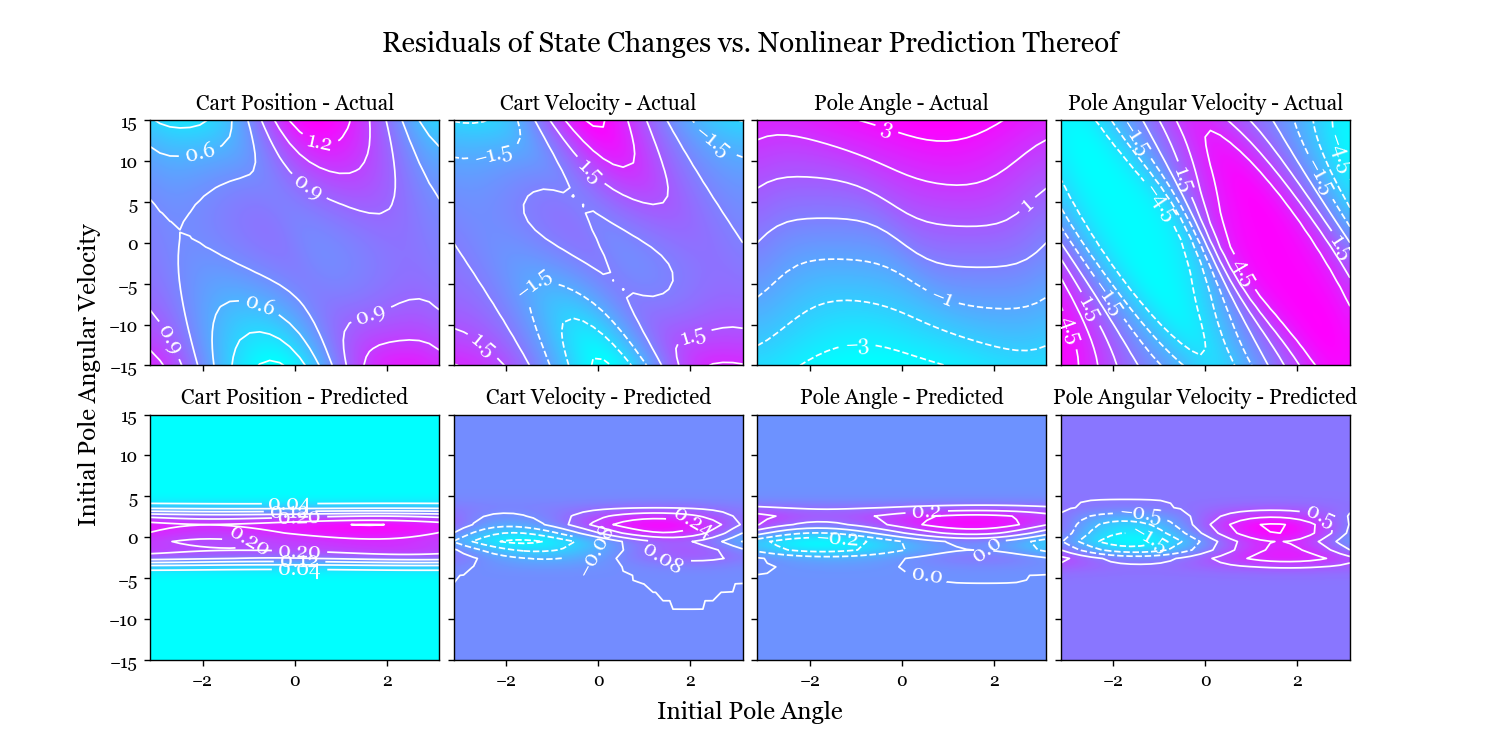

Text(0.06, 0.5, 'Initial Pole Angular Velocity')

In [11]:
fig, axs = plt.subplots(2, 4, num=4, figsize=(12,6), sharex=True, sharey=True )
fig.subplots_adjust(wspace=0.05, hspace=0.2, top=0.84, bottom=0.12, left=0.1, right=0.9)

titles = [["Cart Position - Actual", "Cart Velocity - Actual", "Pole Angle - Actual", "Pole Angular Velocity - Actual"],
          ["Cart Position - Predicted", "Cart Velocity - Predicted", "Pole Angle - Predicted", "Pole Angular Velocity - Predicted"]]

# plot nonlinear prediction contours

for row, axrow in enumerate(axs):
    
    changes = [ state_changes, modelled_changes ][row]
    
    for col, ax in enumerate(axrow):

        ax.imshow( changes[:,:,col], interpolation="bicubic", extent=(-np.pi, np.pi, -15, 15), aspect='auto', cmap="cool", origin='lower' )
        contour = ax.contour( initial_states[0,:,2], initial_states[:,0,3], changes[:,:,col], colors="white", linewidths=1 )
        ax.clabel( contour, contour.levels[1::2], inline=True, fontsize=12 )
        
        ax.set_title( titles[row][col] )
    
fig.text(0.5, 0.94, 'Residuals of State Changes vs. Nonlinear Prediction Thereof', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Initial Pole Angle', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Initial Pole Angular Velocity', ha='center', va='center', rotation='vertical', fontsize=14)


Above are the contour plots of the nonlinear predictions for the state changes, across varying intial pole angle and angular velocity. The nonlinear structure has been captured by the model quite well but it did take a large amount of data and many kernel functions to acheive this. Improvements to the process might include collecting data further outside the region we would like to make predictions in, pushing errors further away from where we are using the model for prediction. Another improvement could be to collect more datapoints in regions with larger errors, or assign different "weights" to different data points, making them more or less important for the model to explain well.

## Plotting Predicted State Changes Against Target State Changes

<IPython.core.display.Javascript object>


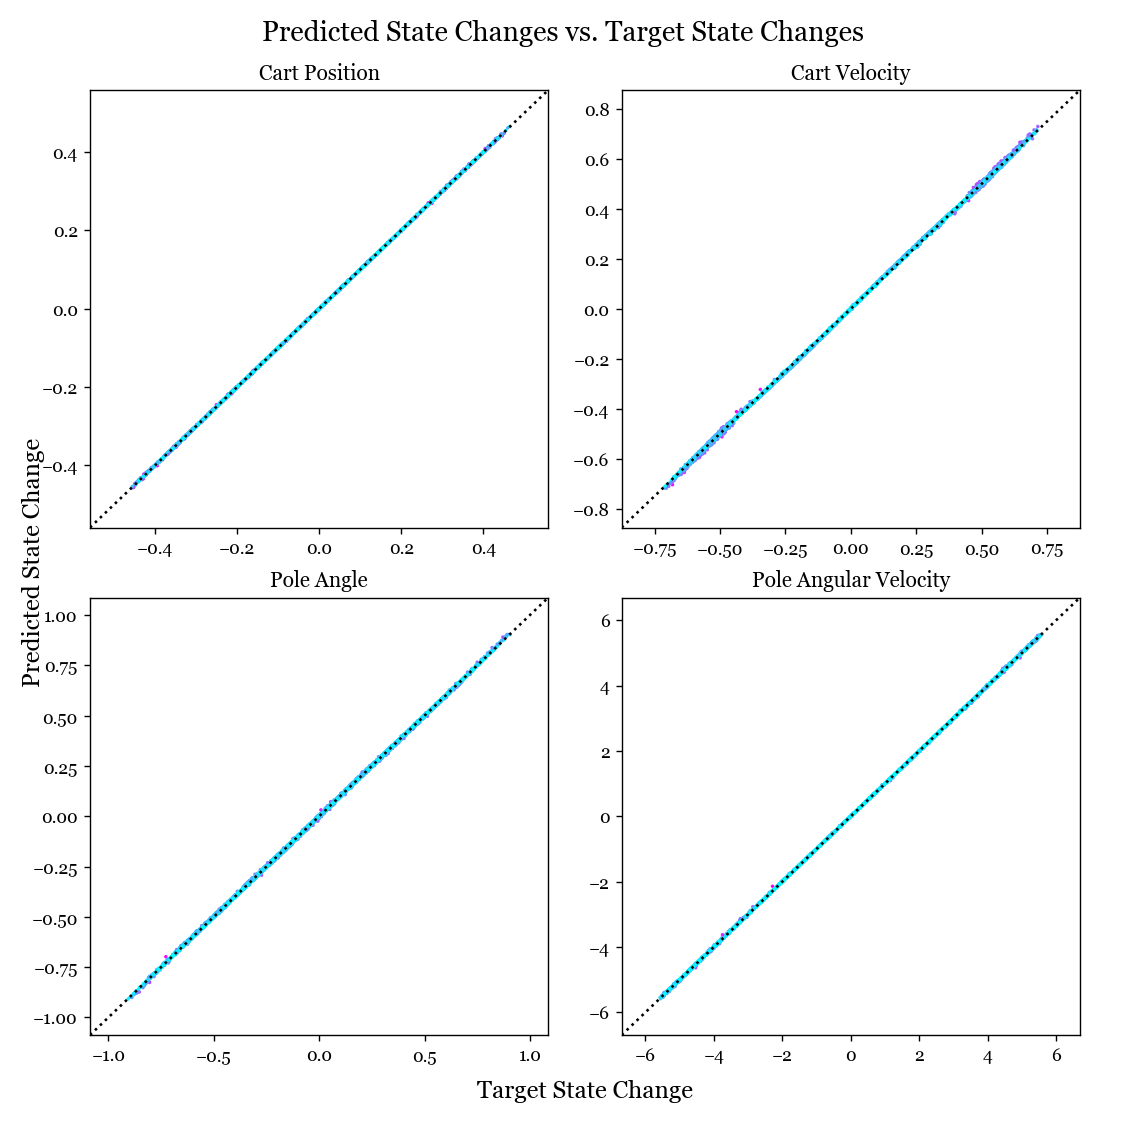

Text(0.03, 0.5, 'Predicted State Change')

In [12]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=19, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

predictions = np.array( [ nonlinear_model(state) for state in X ] )

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):
    
    x, y = predictions[:,i], Y[:,i]
    c = np.abs(x - y)
    
    extent = np.max( ( np.concatenate([x, y]) ) ) * 1.2
    
    ax.scatter( y, x, s=1, c=c, cmap="cool" )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    
    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted" )
    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

Above I have plotted the target state change against the predictions from the linear plus nonlinear model. The points are all lying much closer to the ideal line y=x, so we can expect this model to preform much better than the linear model from task 1.3.

<IPython.core.display.Javascript object>


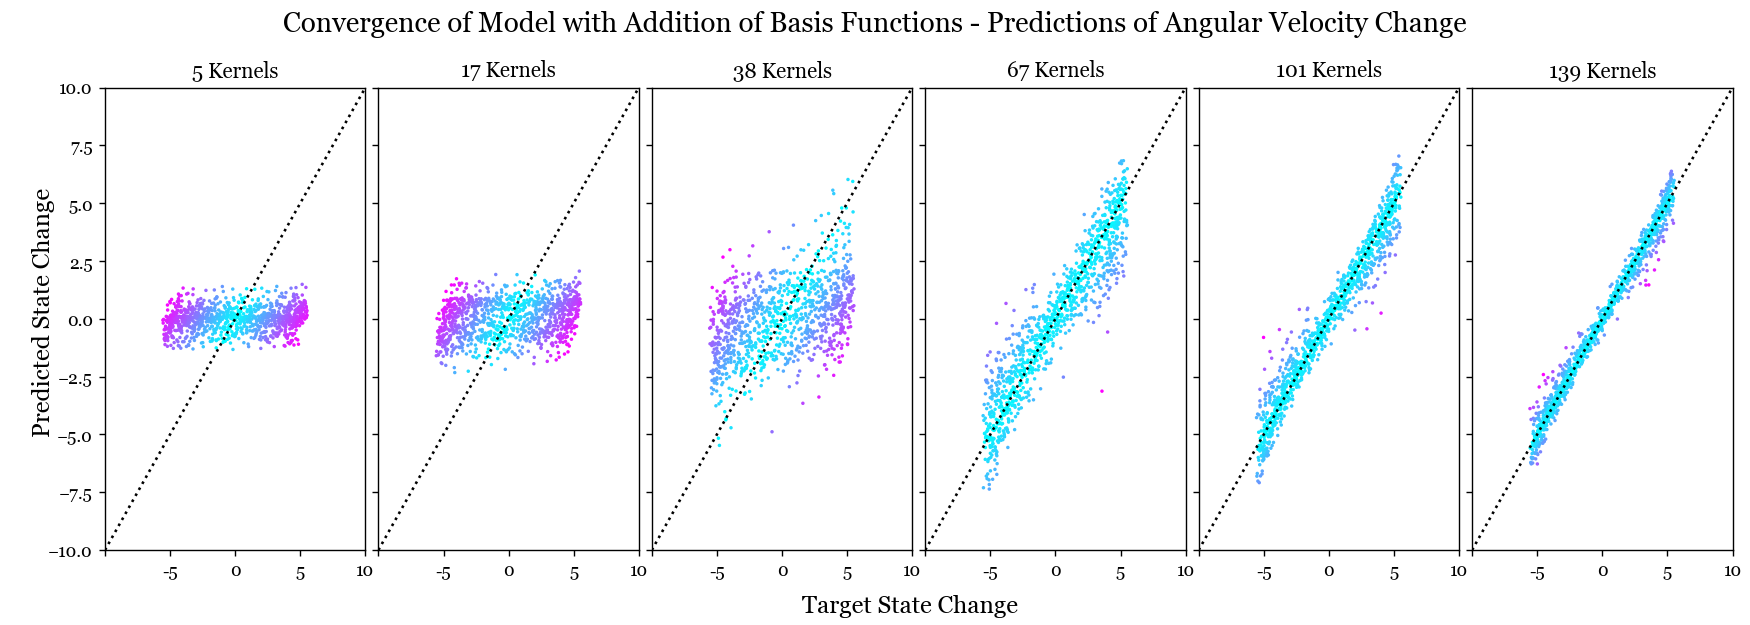

C:\Users\osaha\AppData\Local\Temp\ipykernel_2264\2993564947.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [" ","-5","0","5","10"] )


Text(0.025, 0.5, 'Predicted State Change')

In [13]:
fig, axs = plt.subplots(1, 6, num=9, figsize=(14,5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.05, top=0.86, bottom=0.12, left=0.06, right=0.99)

Ms = [5,10,15,25,40,100]

for p, ax in enumerate( axs ):

    M = int( 5 + 12*p**1.5 )
    #M = Ms[p]
    kernel_centres = X[:M]

    Xplus = np.linalg.inv(X.T @ X) @ X.T
    C = Xplus @ Y

    # loop over the kernel centres and evaluate the K function across all the Xs at each
    Kmn = np.zeros( (M,N) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmn[i] = K( X, kernel_centre[np.newaxis] )

    # same as above but only use first M vectors from X
    Kmm = np.zeros( (M,M) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


    l = 1e-4

    KmnKnm = Kmn @ Kmn.T
    a = KmnKnm + l * Kmm
    b = Kmn @ Y

    alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

    Npoints = 1024
    
    predictions = np.array( [ nonlinear_model(state) for state in X[:Npoints] ] )

    x, y = predictions[:,3], Y[:Npoints,3]
    c = np.abs(x - y)

    extent = 10

    ax.scatter( y, x, s=1, c=c, cmap="cool" )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)

    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted" )

    ax.set_title( f'{M} Kernels' )
    ax.set_xticklabels( [" ","-5","0","5","10"] )

fig.text(0.5, 0.96, 'Convergence of Model with Addition of Basis Functions - Predictions of Angular Velocity Change', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.025, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)



Above I ahve plotted the prediction for change in pole angular velocity against the actual change for a few different numbers of basis functions. As the number of basis functions increases, the fit converges but plateaus before acheiving a perfect fit.

## Performing Rollouts with the Nonlinear Model

<IPython.core.display.Javascript object>


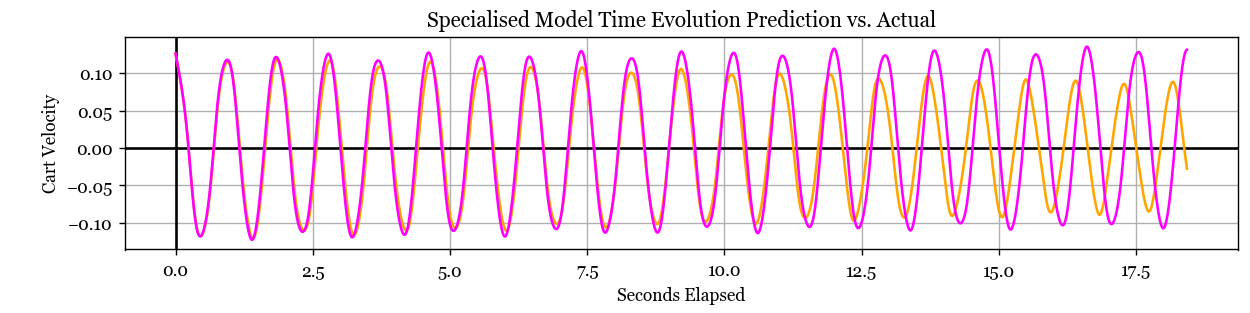

Text(0, 0.5, 'Cart Velocity')

In [101]:
kernel_centres = cache["kernel_centres_fitted"]
alpha_m = cache["alpha_m_fitted"]

fig, ax = plt.subplots(1, 1, num=14, figsize=(10,2.5))
fig.subplots_adjust(bottom=0.2, right=0.99, left=0.1)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

predicted_state = np.array( [0, 0.126, np.pi, 1] )
actual_state = np.array( [0, 0.126, np.pi, 1] )

prediction_states = []
actual_states = []
time = []

for i in range(100):
    
    prediction_states.append( predicted_state )
    actual_states.append( actual_state )
    time.append( i * 0.2 )
    
    predicted_state = nonlinear_model( predicted_state ) + predicted_state
    actual_state    = CartPole.perform_action( actual_state )

prediction_states = np.array( prediction_states )
actual_states = np.array( actual_states )
time = np.array( time )

x = time
y1 = prediction_states[:,1]
y2 = actual_states[:,1]


f, u = scipy.interpolate.splprep( [x, y1], s=0, per=True )
xint, y1int = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)
xint, y1int = xint[:5000], y1int[:5000]

f, u = scipy.interpolate.splprep( [x, y2], s=0, per=True )
_, y2int = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)
y2int = y2int[:5000]

ax.plot( xint, y2int, color="orange" )
ax.plot( xint, y1int, color="magenta" )

ax.set_title("Specialised Model Time Evolution Prediction vs. Actual")
ax.set_xlabel("Seconds Elapsed")
ax.set_ylabel("Cart Velocity")

In order to improve the model's predictions, I restricted the training data to the range relevant to small amplitude oscillations and then examined the time evolution of the predictions in that same regime. The plot above shows the actual dynamics in orange, and the model predicitons in magenta. The predictions are very good up to about 10 seconds after which the real oscillations decay; the model is unable to capture this behaviour as this is a 

<IPython.core.display.Javascript object>


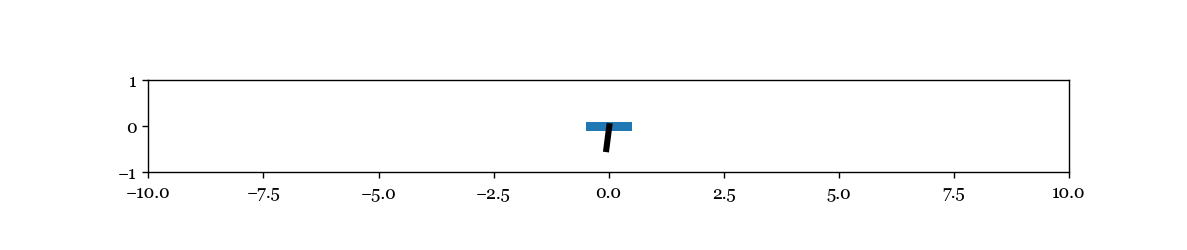

In [15]:
c = CartPole.CartPole( visual=True, smooth=True, fig_num=25 )
c.cart_velocity = 0.126
c.pole_angvel = 1

In [16]:
for i in range(10):
    
    #c.perform_action()
    state = c.get_state()
    c.set_state( nonlinear_model( state ) + state )
    c._render()